In [332]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.ticker as ticker
from arch import arch_model
from sklearn.linear_model import LinearRegression

Считаем датасет из файла

In [333]:
df = pd.read_csv("data/ghana_gdp.csv", parse_dates=['year'], index_col=['year'])

In [334]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Значения ВВП по годам представлены на гафике ниже

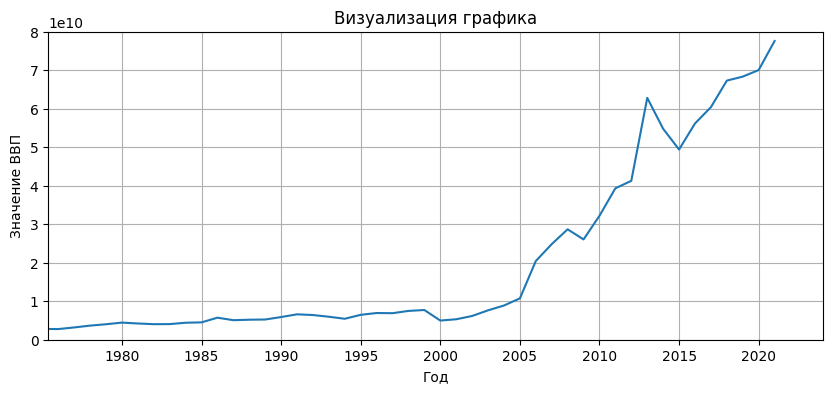

In [335]:
_, axs = plt.subplots(figsize=(10, 4))
axs.plot(df)
axs.set_xlim(left=pd.to_datetime('1960').year)
axs.set_ylim(bottom=0, top=8*10**10)
axs.set_xlabel('Год')
axs.set_ylabel('Значение ВВП')
axs.set_title("Визуализация графика")
axs.grid()

Декомпозиция данных приведена грфике ниже

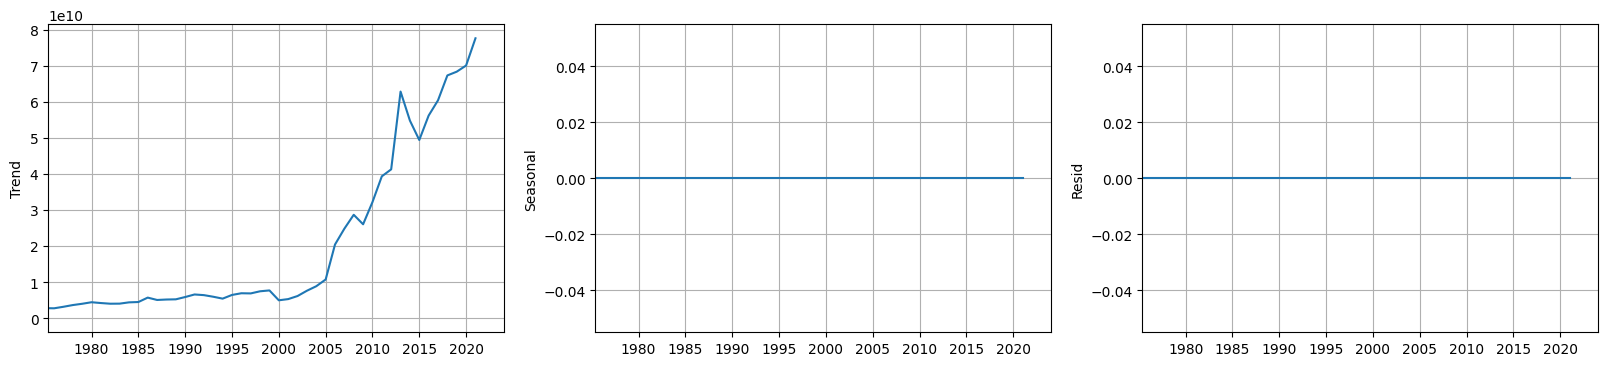

In [336]:
decomposition = seasonal_decompose(df)

_, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

for ax, j, label in zip(axs, 
                 [decomposition.trend, decomposition.seasonal, decomposition.resid],
                 ['Trend', 'Seasonal', 'Resid']):
    ax.plot(j)
    ax.set_ylabel(label)
    ax.grid()
    ax.set_xlim(left=pd.to_datetime('1960').year)

Из графиков видно, что в данных отсутсвует сезонность и шум. Явно выделяется только тренд.

Разделение данных на тренировочную и тестовую выборку:

In [337]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

На графике ниже приведено сранение исходных данных и скользящих средних, созданных по этим же данным.

(0.0, 80000000000.0)

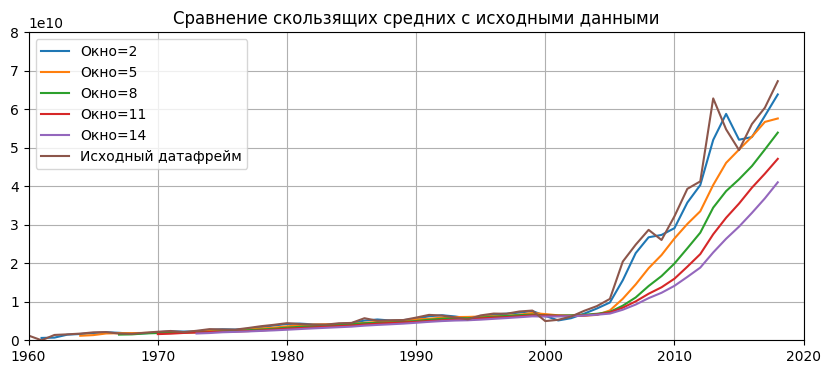

In [338]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

for i in range(2, 15, 3):
    ma = train_df.rolling(window=i).mean()
    ma.fillna(0)
    axs.plot(ma, label=f"Окно={i}")

axs.plot(train_df, label="Исходный датафрейм")
axs.grid()
axs.legend()
axs.set_title("Сравнение скользящих средних с исходными данными")
axs.set_xlim(left=pd.to_datetime("1960-01-01"), right=pd.to_datetime("2020-01-01"))
axs.set_ylim(bottom=0, top=8*10**10)  

Из графика видно, что вид скользящих средних повторяет исходные данные

Проведем теста Дики — Фуллера для определения стационарности ряда

In [339]:
result = adfuller(train_df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: 0.6529066974885396
p-value: 0.9888496277665573
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


Значение статистики выше критического значения выбранного уровня значимости, принимаем гипотезу H0 (ряд нестационарный). Необходимо произвести дифференцирование ряда

In [340]:
d = 1
diff_df = train_df.diff().dropna()

while True:
    test = adfuller(diff_df)
    print(f"d-value - {d}")
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    print("-" * 100)
    if test[0] < test[4]['5%']: 
        break
    d += 1
    diff_df = diff_df.diff().dropna()

d-value - 1
adf:  -1.6702483038320788
p-value:  0.4465029329713885
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
----------------------------------------------------------------------------------------------------
d-value - 2
adf:  -2.6408690561284875
p-value:  0.08484116917837708
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
----------------------------------------------------------------------------------------------------
d-value - 3
adf:  -4.779623784828544
p-value:  5.948327640224588e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
----------------------------------------------------------------------------------------------------


Произведена сереия дифференцирований. Их колличество (значение d) равно 3

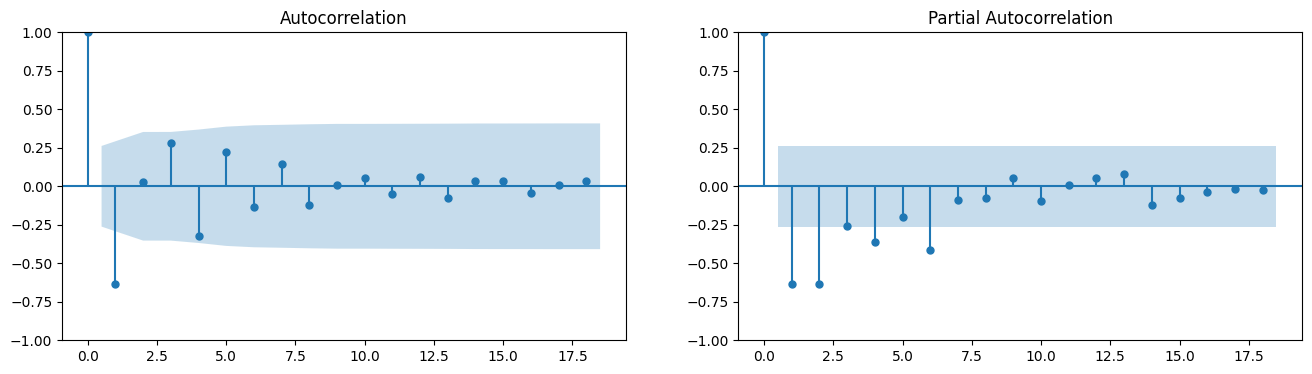

In [341]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

plot_acf(diff_df.values, ax=axs[0])
plot_pacf(diff_df.values, ax=axs[1], method="ywm")

plt.show()

Исходя анализа графиков автокорреляции и частичной автокорреляции значения p и q равны 1 и 1 соответсвенно.

In [342]:
p = 1
q = 1

In [343]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

Т.к. ряд стационарный и не имеет сезонности, можно применить модель ARIMA

In [344]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, q, d))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1356.763
Date:                Fri, 10 Mar 2023   AIC                           2723.526
Time:                        10:35:56   BIC                           2733.828
Sample:                    01-01-1960   HQIC                          2727.539
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7900      0.109      7.253      0.000       0.577       1.004
ma.L1         -0.9608      0.185     -5.200      0.000      -1.323      -0.599
ma.L2         -0.1871      0.256     -0.731      0.465      -0.689       0.314
ma.L3          0.6075      0.197      3.082      0.002       0.221       0.994
sigma2      1.459e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               302.98
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):             132.73   Skew:                             2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.87e+56. Standard errors may be unstable.
"""

In [345]:
smodel = pm.auto_arima(
    train_df, start_p=1, d=1,
    start_q=1, max_p=3, max_q=3,
    D=1, start_P=0, m=5, test="adf",
    error_action="ignore", trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.818, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.375, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.844, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.273, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.02 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=2493.670, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.817, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.547, Time=0.02 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2490.649, Time=0.06 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2497.730, Time=0.04 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2492.646, Time=0.06 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2492.644, Time=0.09 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.136
Date:                                Fri, 10 Mar 2023   AIC                           2486.272
Time:                                        10:35:59   BIC                           2502.034
Sample:                                    01-01-1960   HQIC                          2492.333
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4208      0.148     -2.845      0.004      -0.711      -0.131
ar.L2         -0.9986      0.191     -5.222      0.000      -1.373      -0.624
ma.L1          0.3703      0.243      1.522      0.128      -0.107       0.847
ma.L2          0.9203      0.214      4.306      0.000       0.501       1.339
ma.L3          0.4157      0.197      2.110      0.035       0.030       0.802
ma.S.L5        0.0466      0.270      0.173      0.863      -0.483       0.576
ma.S.L10      -0.4504      0.314     -1.434      0.152      -1.066       0.165
sigma2      1.363e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                72.42
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              63.08   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.25e+53. Standard errors may be unstable.
"""

После проведения сеточного анализа были определены значения d, p, q при котороых модель дает более качественное предсказание: значение AIC (2486.272) ниже предыдущего значения (2723.526)

In [346]:
best_arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(2,1,3))
best_arima_model_fit = arima_model.fit()
best_arima_model_fit.summary()

/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1356.763
Date:                Fri, 10 Mar 2023   AIC                           2723.526
Time:                        10:35:59   BIC                           2733.828
Sample:                    01-01-1960   HQIC                          2727.539
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7900      0.109      7.253      0.000       0.577       1.004
ma.L1         -0.9608      0.185     -5.200      0.000      -1.323      -0.599
ma.L2         -0.1871      0.256     -0.731      0.465      -0.689       0.314
ma.L3          0.6075      0.197      3.082      0.002       0.221       0.994
sigma2      1.459e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               302.98
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):             132.73   Skew:                             2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.87e+56. Standard errors may be unstable.
"""

In [347]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = best_arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = best_arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

# Сделано, что-бы убрать разрыв в графике
pred_df["model_preds"][-4] = df.iloc[-4]
pred_df["model_preds_lower"][-4] = df.iloc[-4]
pred_df["model_preds_upper"][-4] = df.iloc[-4]

pred_df.set_index(pd.Series(pred_df.index).dt.year, inplace=True)


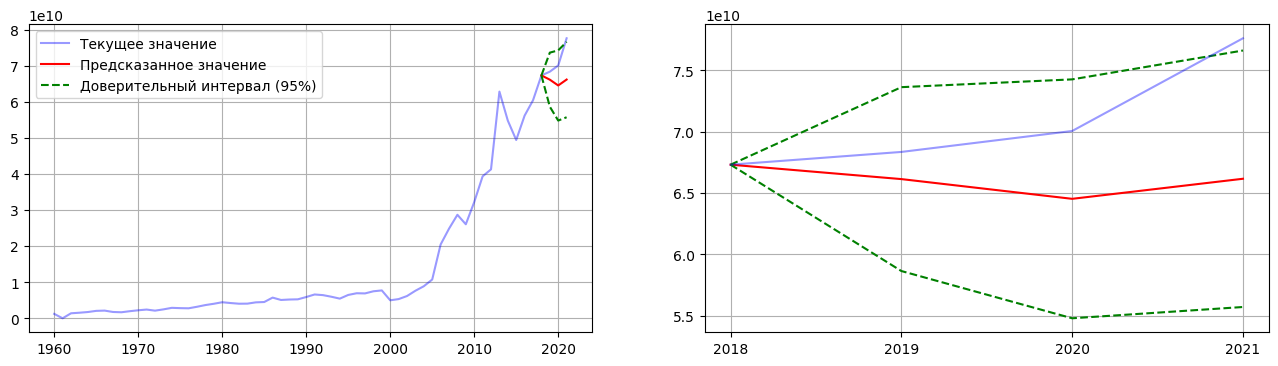

In [348]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axs[0].plot(pred_df["GDP (current US$)"], color="blue", label="Текущее значение", alpha=0.4)

axs[0].plot(pred_df.loc[pred_df.index[-4:]]["model_preds"], color="red", label="Предсказанное значение")
axs[0].plot(pred_df.loc[pred_df.index[-4:]]["model_preds_lower"], color="green", linestyle="--", label="Доверительный интервал (95%)",)
axs[0].plot(pred_df.loc[pred_df.index[-4:]]["model_preds_upper"], color="green", linestyle="--")
axs[0].legend()
axs[0].grid()

axs[1].plot(pred_df.loc[pred_df.index[-4:]]["model_preds"], color="red")
axs[1].plot(pred_df.loc[pred_df.index[-4:]]["model_preds_lower"], color="green", linestyle="--")
axs[1].plot(pred_df.loc[pred_df.index[-4:]]["model_preds_upper"], color="green", linestyle="--")
axs[1].plot(pred_df.loc[pred_df.index[-4:]]["GDP (current US$)"], color="blue", alpha=0.4)
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1].grid()

После обучения и тестировани новой модели получены следующие результаты (см. графики выше).

Реальные значения входят в 95% доверительный интервал предсказанных результатов. Видно, что на интервале 2018-2020 предсказанные значения имеют нисходящий тренд, в то время как тестовые данные показываю восходящий, но, начиная с 2020 тренды совпадают. В целом, можно сказать, что модель достаточно точно предсказывает поведение временного ряда на небольшом интервале.  

Анализ ряда на пропуски и нули

In [349]:
print(f"Количество пропущенных дат - {df.asfreq(freq='AS').isna().sum().sum()}")
print(f"Количество пропущенных значений - {df.isna().sum().sum()}")
print(f"Количество нулей - {df[df['GDP (current US$)'] == 0].count().count()}")

df[df.values == 0]

Количество пропущенных дат - 0
Количество пропущенных значений - 0
Количество нулей - 1


,GDP (current US$)
year,
1961-01-01,0.0


Найдено одно нулевое значение. Применим интерполяцию.

In [350]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x == 0 else x)
int_df = pd.DataFrame(df['GDP (current US$)'].interpolate(method='linear'))

График ряда приянл вид:  

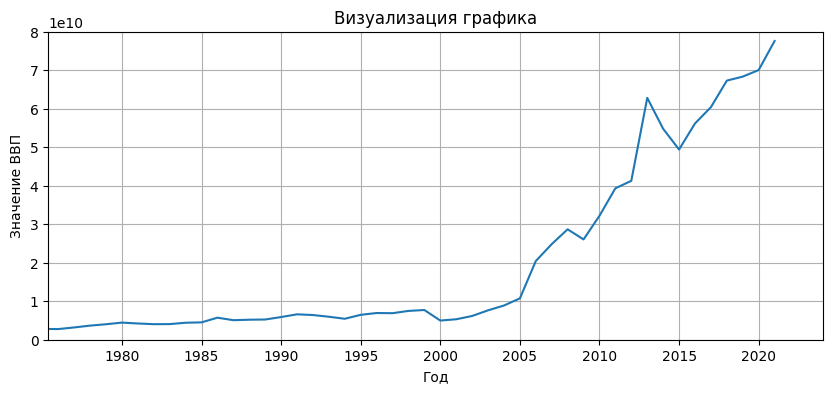

In [351]:
_, axs = plt.subplots(figsize=(10, 4))
axs.plot(int_df)
axs.set_xlim(left=pd.to_datetime('1960').year)
axs.set_ylim(bottom=0, top=8*10**10)
axs.set_xlabel('Год')
axs.set_ylabel('Значение ВВП')
axs.set_title("Визуализация графика")
axs.grid()

In [352]:
train_df = int_df.iloc[:-3]
test_df = int_df.iloc[-3:]

Применим несколько циклов дифференцирования

In [353]:
d = 1
diff_df = train_df.diff().dropna()

while True:
    test = adfuller(diff_df)
    print(f"d-value - {d}")
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    print("-" * 100)
    if test[0] < test[4]['5%']: 
        break
    d += 1
    diff_df = diff_df.diff().dropna()

d-value - 1
adf:  -1.8255652246436003
p-value:  0.36784515276563406
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
----------------------------------------------------------------------------------------------------
d-value - 2
adf:  -2.634634746007848
p-value:  0.08604813722197563
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
----------------------------------------------------------------------------------------------------
d-value - 3
adf:  -4.825603687304042
p-value:  4.8573180767994686e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
----------------------------------------------------------------------------------------------------


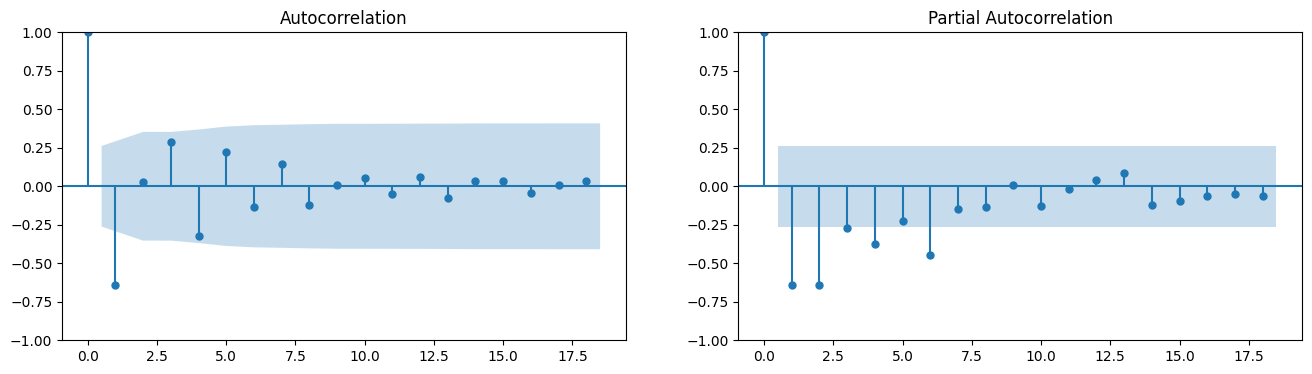

In [354]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

plot_acf(diff_df.values, ax=axs[0])
plot_pacf(diff_df.values, ax=axs[1], method="ywm")

plt.show()

Исходя анализа графиков автокорреляции и частичной автокорреляции значения p и q равны 1 и 1 соответсвенно.

In [355]:
p = 1
q = 1

In [356]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, q, d))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1356.621
Date:                Fri, 10 Mar 2023   AIC                           2723.242
Time:                        10:36:00   BIC                           2733.544
Sample:                    01-01-1960   HQIC                          2727.255
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7848      0.116      6.791      0.000       0.558       1.011
ma.L1         -0.9458      0.198     -4.767      0.000      -1.335      -0.557
ma.L2         -0.2090      0.272     -0.769      0.442      -0.741       0.323
ma.L3          0.6223      0.207      3.001      0.003       0.216       1.029
sigma2      1.457e+19   6.82e-21   2.14e+39      0.000    1.46e+19    1.46e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               312.12
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):             520.01   Skew:                             2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.74e+55. Standard errors may be unstable.
"""

После обучения на преобразованных данных модель показала незначительное улучшение: AIC = 2723.242 по сравнению с необработанными данными AIC = 2723.526

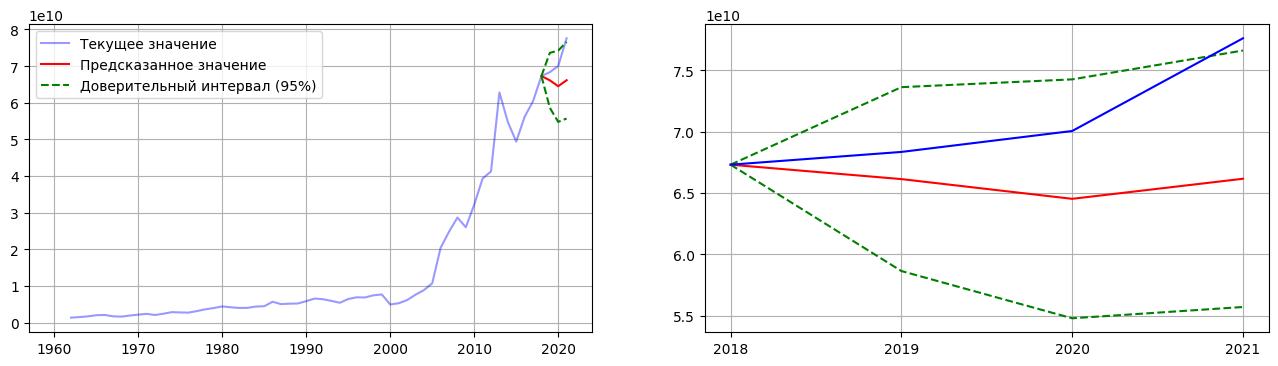

In [357]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = best_arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = best_arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

# Сделано, что-бы убрать разрыв в графике
pred_df["model_preds"][-4] = df.iloc[-4]
pred_df["model_preds_lower"][-4] = df.iloc[-4]
pred_df["model_preds_upper"][-4] = df.iloc[-4]

pred_df.set_index(pd.Series(pred_df.index).dt.year, inplace=True)

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axs[0].plot(pred_df["GDP (current US$)"], color="blue", label="Текущее значение", alpha=0.4)

axs[0].plot(pred_df.loc[pred_df.index[-4:]]["model_preds"], color="red", label="Предсказанное значение")
axs[0].plot(pred_df.loc[pred_df.index[-4:]]["model_preds_lower"], color="green", linestyle="--", label="Доверительный интервал (95%)",)
axs[0].plot(pred_df.loc[pred_df.index[-4:]]["model_preds_upper"], color="green", linestyle="--")
axs[0].legend()
axs[0].grid()

axs[1].plot(pred_df.loc[pred_df.index[-4:]]["model_preds"], color="red")
axs[1].plot(pred_df.loc[pred_df.index[-4:]]["model_preds_lower"], color="green", linestyle="--")
axs[1].plot(pred_df.loc[pred_df.index[-4:]]["model_preds_upper"], color="green", linestyle="--")
axs[1].plot(pred_df.loc[pred_df.index[-4:]]["GDP (current US$)"], color="blue")
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1].grid()

Визуально улучшений не видно

In [358]:
int_df["gdp_vol"] = int_df.pct_change(1).mul(100).abs()
int_df.dropna(inplace=True)
int_df["gdp_vol"].head()

year
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
1965-01-01    18.608414
Name: gdp_vol, dtype: float64

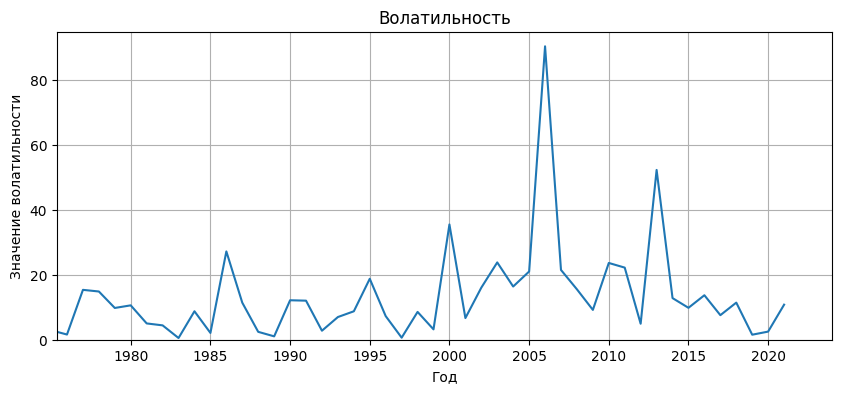

In [359]:
_, axs = plt.subplots(figsize=(10, 4))

axs.plot(int_df["gdp_vol"])
axs.set_xlim(left=pd.to_datetime('1960').year)
axs.set_ylim(bottom=0)
axs.set_xlabel('Год')
axs.set_ylabel('Значение волатильности')
axs.set_title("Волатильность")
axs.grid()

In [360]:
train_df = int_df.iloc[:-3]
test_df = int_df.iloc[-3:]

In [361]:
test = adfuller(train_df['gdp_vol'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
print("-" * 100)

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
----------------------------------------------------------------------------------------------------


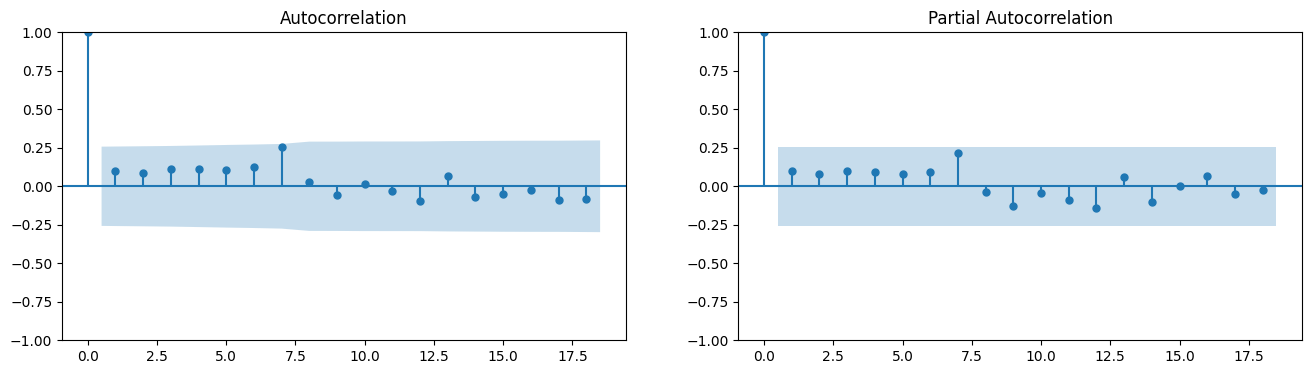

In [362]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

plot_acf(train_df['gdp_vol'].values, ax=axs[0])
plot_pacf(train_df['gdp_vol'].values, ax=axs[1], method="ywm")

plt.show()

Исходя из графиков значения p и q равны 7 

In [363]:
p = 7
q = 7

In [364]:
garch_df = pd.DataFrame(int_df["gdp_vol"].loc[int_df.index])
garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

In [365]:
train_df.index[-1]

Timestamp('2018-01-01 00:00:00')

In [366]:
model = arch_model(garch_df["gdp_vol"].dropna(), p=p, q=q)

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

model_results.summary()

predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.3804453855118
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759238213878
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40874513901056
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10037247804192
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01210032831344
Iteration:     30,   Func. Count:    520,   Neg. LLF: 214.412820461264
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00749426002182
            Iterations: 31
            Function evaluations: 524
            Gradient evaluations: 30


/home/ivan/Desktop/Python Projects/time_series_task/venv2/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [367]:
predictions_df.set_index(pd.Series(predictions_df.index).dt.year, inplace=True)

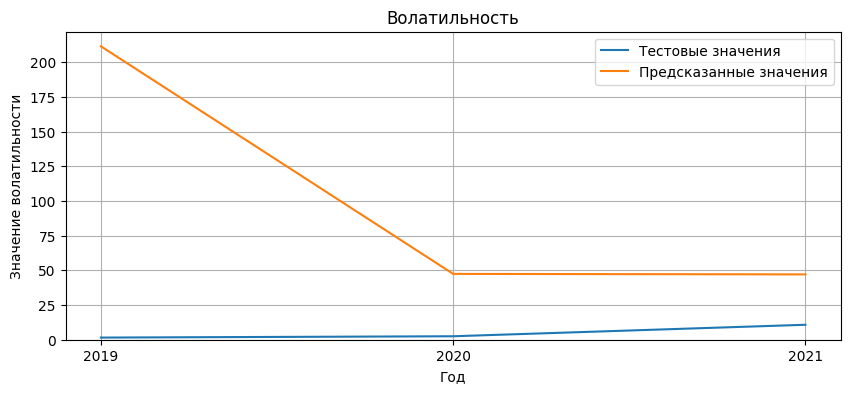

In [368]:
_, axs = plt.subplots(figsize=(10, 4))

axs.plot(predictions_df["gdp_vol"].abs(), label="Тестовые значения")
axs.plot(predictions_df["Predictions"], label="Предсказанные значения")
axs.set_ylim(bottom=0)
axs.set_xlabel('Год')
axs.set_ylabel('Значение волатильности')
axs.set_title("Волатильность")
axs.grid()
axs.legend()
axs.xaxis.set_major_locator(ticker.MultipleLocator(1))

Предсказанные значения очень сильно (на порядки) отличаются от тестовых. Модель не уловила волотильность исследуемого временного ряда.

Обучим модель линейной регрессии

In [369]:
X_train = pd.DataFrame(range(int_df["gdp_vol"].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(int_df["gdp_vol"].shape[0]))[train_df.shape[0]:].fillna(0)

y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)

In [370]:
lr = LinearRegression()

Проверка на тренировочных данных

In [371]:
lr.fit(X_train.values, y_train.values)
train_df['Predictions'] = lr.predict(X_train.values)

/tmp/ipykernel_162371/240974041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Predictions'] = lr.predict(X_train.values)


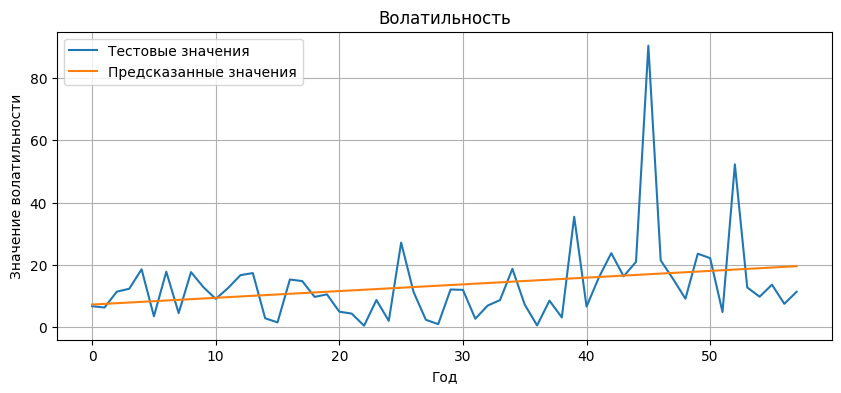

In [372]:
_, axs = plt.subplots(figsize=(10, 4))

axs.plot(train_df["gdp_vol"].values, label="Тестовые значения")
axs.plot(train_df["Predictions"].values, label="Предсказанные значения")
axs.set_xlabel('Год')
axs.set_ylabel('Значение волатильности')
axs.set_title("Волатильность")
axs.grid()
axs.legend()

Проверка на тестовых данных

In [373]:
lr.fit(X_test.values, X_test.values)
test_df['Predictions'] = lr.predict(X_test.values)

/tmp/ipykernel_162371/3816991979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = lr.predict(X_test.values)


In [374]:
test_df.set_index(pd.Series(test_df.index).dt.year, inplace=True)

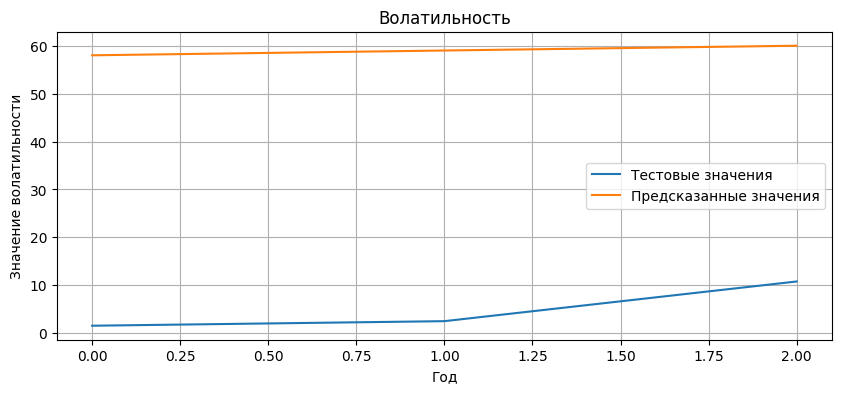

In [375]:
_, axs = plt.subplots(figsize=(10, 4))

axs.plot(test_df["gdp_vol"].values, label="Тестовые значения")
axs.plot(test_df["Predictions"].values, label="Предсказанные значения")
axs.set_xlabel('Год')
axs.set_ylabel('Значение волатильности')
axs.set_title("Волатильность")
axs.grid()
axs.legend()

Модель линейной регрессии так-же не показала хороших результатов